# Working with tabular data

## Przemysław Szufel

In the workshop we will use a subsetted version of https://database.lichess.org/#puzzles database.

Each record of this data base has the following fields:
* `Moves`: All player moves of the solution are "only moves". I.e. playing any other move would considerably worsen the player position. An exception is made for mates in one: there can be several. Any move that checkmates should win the puzzle.
* `Rating`: To determine the rating, each attempt to solve is considered as a Glicko2 (see https://en.wikipedia.org/wiki/Glicko_rating_system) rated game between the player and the puzzle.
* `Popularity`: Popularity is a number between 100 (best) and -100 (worst). It is calculated as (upvotes - downvotes)/(upvotes + downvotes).
* `Themes`: Chess themes associated with a given puzzle. You can find a list of themes, their names and descriptions, in this file: https://github.com/ornicar/lila/blob/master/translation/source/puzzleTheme.xml.
* `OpeningFamily`: The Opening fields are only set for puzzles starting before move 20. Here's the list of possible openings.

In this workshop we will want to check what factors affect chess puzzle popularity.

We use `puzzles.parquet` file that stores a subset of the original data.

### Load the required packages

In [39]:
using DataFramesMeta

In [40]:
using FreqTables

In [41]:
using GLM

In [42]:
using Parquet2

In [43]:
using Plots

In [44]:
using StatsBase

In [45]:
using Statistics

### Load the source data

In [46]:
ds = Parquet2.Dataset("puzzles.parquet")

≔ Parquet2.Dataset (10280073 bytes)
	1. "Moves": String
	2. "Rating": Int64
	3. "Popularity": Int64
	4. "NbPlays": Int64
	5. "Themes": String
	6. "OpeningFamily": String


In [47]:
df = DataFrame(ds)

565133×6 DataFrame
    Row │ Moves                              Rating  Popularity  NbPlays  Them ⋯
        │ String                             Int64   Int64       Int64    Stri ⋯
────────┼───────────────────────────────────────────────────────────────────────
      1 │ b6c5 e2g4 h3g4 d1g4                  1088          85      505  adva ⋯
      2 │ g5e7 a5c3 b2c3 c6e7                  1457          86      482  adva
      3 │ e8f7 e2e6 f7f8 e6f7                  1595          88      448  mate
      4 │ d8f6 d1h5 h7h6 h5c5                  1762          90     1572  adva
      5 │ c7a8 a5c3                            1013          39      136  bode ⋯
      6 │ h2g3 g6h5                            1490          50       12  mate
      7 │ f2f3 d6c5 g1h1 c5c4                   943          96     1091  adva
      8 │ d3a6 b6c5 a6c8 c5c4                  1927          93      639  crus
   ⋮    │                 ⋮                    ⋮         ⋮          ⋮          ⋱
 565127 │ e4c3 a4c6 d8d7 c6c3                  1401          72       30  adva ⋯
 565128 │ e4c3 e2e8 f8e8 e1e8 g8h7 b2c3        1805         100       13  crus
 565129 │ a5a2 b5c7 e8d7 c7a8                   812         100       52  crus
 565130 │ b8d7 c3b5 d6b8 a1c1 e8g8 b5c7        1811          94     2523  crus
 565131 │ g5c1 d5d6 d7f6 h7h8                  1899          85       73  adva ⋯
 565132 │ d2f3 d8a5 c1d2 a5b5                   972          93      637  adva
 565133 │ c6d4 f1e1 e8d8 b1c3 d4f3 g2f3        2496          79       50  adva
                                               2 columns and 565118 rows omitted

### Preliminary inspection of the descriptive statistics of the data

In [48]:
describe(df)

6×7 DataFrame
 Row │ variable       mean     min                                median  max  ⋯
     │ Symbol         Union…   Any                                Union…  Any  ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Moves                   a1a2 a3b4 c6b4 d3d6 e7e8 b5c7              h8h7 ⋯
   2 │ Rating         1578.6   550                                1544.0  2914
   3 │ Popularity     82.1303  -100                               89.0    171
   4 │ NbPlays        1046.09  0                                  243.0   2412
   5 │ Themes                  advancedPawn advantage attacking…          open ⋯
   6 │ OpeningFamily           Alekhine_Defense                           Zuke
                                                               3 columns omitted

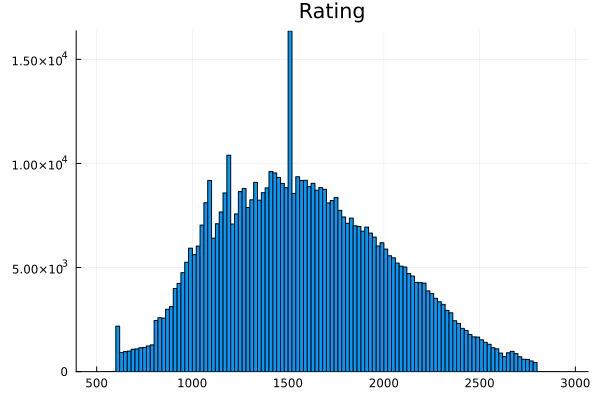

In [49]:
histogram(df.Rating, legend=false, title="Rating")

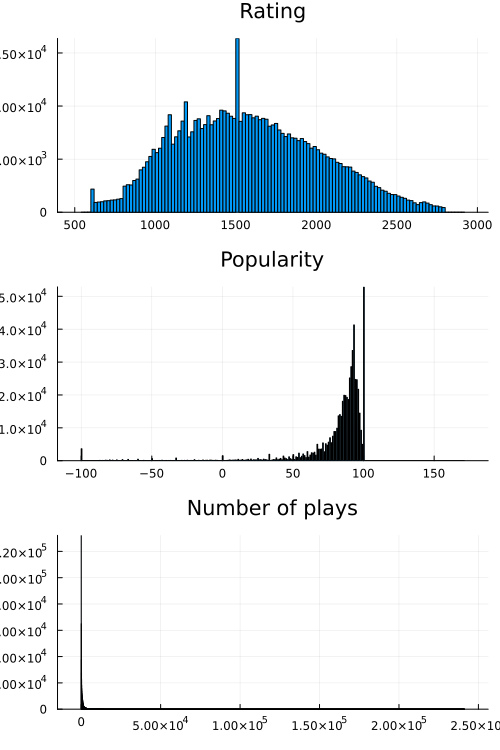

In [50]:
plot(
     histogram(df.Rating, legend=false, title="Rating"),
     histogram(df.Popularity, legend=false, title="Popularity"),
     histogram(df.NbPlays, legend=false, title="Number of plays"),
     layout=(3, 1), size=(500, 750)
    )

### Analyzing themes

In [51]:
df.Themes

565133-element Parquet2.StringRefVector{String, WeakRefStrings.WeakRefString}:
 "advantage middlegame short"
 "advantage master middlegame short"
 "mate mateIn2 middlegame short"
 "advantage middlegame short"
 "bodenMate hangingPiece mate mateIn1 middlegame oneMove"
 "mate mateIn1 oneMove"
 "advantage fork master masterVsMaster middlegame short"
 "crushing master masterVsMaster middlegame sacrifice short"
 "advantage opening short trappedPiece"
 "advantage fork middlegame short"
 ⋮
 "advantage long middlegame"
 "advantage middlegame pin short"
 "advantage fork middlegame short"
 "crushing kingsideAttack long"
 "crushing fork middlegame short"
 "crushing long middlegame quietMove"
 "advantage middlegame short"
 "advantage fork opening short"
 "advantage long opening"

In [52]:
split(first(df.Themes))

3-element Vector{SubString{String}}:
 "advantage"
 "middlegame"
 "short"

In [53]:
themes = String[]
for ts in df.Themes
    for t in split(ts)
        push!(themes, t)
    end
end

In [54]:
themes

2247025-element Vector{String}:
 "advantage"
 "middlegame"
 "short"
 "advantage"
 "master"
 "middlegame"
 "short"
 "mate"
 "mateIn2"
 "middlegame"
 ⋮
 "middlegame"
 "short"
 "advantage"
 "fork"
 "opening"
 "short"
 "advantage"
 "long"
 "opening"

In [55]:
freqtable(themes)

54-element Named Vector{Int64}
Dim1              │ 
──────────────────┼───────
advancedPawn      │   6656
advantage         │ 275745
anastasiaMate     │    290
arabianMate       │     53
attackingF2F7     │   6405
attraction        │  17163
backRankMate      │   6004
bishopEndgame     │      1
⋮                        ⋮
short             │ 357787
skewer            │   6976
smotheredMate     │   1459
superGM           │    243
trappedPiece      │  18628
underPromotion    │     18
veryLong          │  28723
xRayAttack        │    755

In [56]:
sort(freqtable(themes), rev=true)

54-element Named Vector{Int64}
Dim1              │ 
──────────────────┼───────
middlegame        │ 415327
short             │ 357787
advantage         │ 275745
crushing          │ 210525
long              │ 129508
fork              │  93090
opening           │  84115
mate              │  78658
⋮                        ⋮
doubleBishopMate  │    212
hookMate          │    126
dovetailMate      │    105
arabianMate       │     53
underPromotion    │     18
rookEndgame       │     12
queenRookEndgame  │      4
bishopEndgame     │      1

### Finding mating puzzles

In [57]:
sort(unique(t for t in themes if contains(lowercase(t), "mate")))

14-element Vector{String}:
 "anastasiaMate"
 "arabianMate"
 "backRankMate"
 "bodenMate"
 "doubleBishopMate"
 "dovetailMate"
 "hookMate"
 "mate"
 "mateIn1"
 "mateIn2"
 "mateIn3"
 "mateIn4"
 "mateIn5"
 "smotheredMate"

In [58]:
for i in 2:5
    df[:, "mateIn$i"] = contains.(df.Themes, "mateIn$i")
end

In [59]:
df

565133×10 DataFrame
    Row │ Moves                              Rating  Popularity  NbPlays  Them ⋯
        │ String                             Int64   Int64       Int64    Stri ⋯
────────┼───────────────────────────────────────────────────────────────────────
      1 │ b6c5 e2g4 h3g4 d1g4                  1088          85      505  adva ⋯
      2 │ g5e7 a5c3 b2c3 c6e7                  1457          86      482  adva
      3 │ e8f7 e2e6 f7f8 e6f7                  1595          88      448  mate
      4 │ d8f6 d1h5 h7h6 h5c5                  1762          90     1572  adva
      5 │ c7a8 a5c3                            1013          39      136  bode ⋯
      6 │ h2g3 g6h5                            1490          50       12  mate
      7 │ f2f3 d6c5 g1h1 c5c4                   943          96     1091  adva
      8 │ d3a6 b6c5 a6c8 c5c4                  1927          93      639  crus
   ⋮    │                 ⋮                    ⋮         ⋮          ⋮          ⋱
 565127 │ e4c3 a4c6 d8d7 c6c3                  1401          72       30  adva ⋯
 565128 │ e4c3 e2e8 f8e8 e1e8 g8h7 b2c3        1805         100       13  crus
 565129 │ a5a2 b5c7 e8d7 c7a8                   812         100       52  crus
 565130 │ b8d7 c3b5 d6b8 a1c1 e8g8 b5c7        1811          94     2523  crus
 565131 │ g5c1 d5d6 d7f6 h7h8                  1899          85       73  adva ⋯
 565132 │ d2f3 d8a5 c1d2 a5b5                   972          93      637  adva
 565133 │ c6d4 f1e1 e8d8 b1c3 d4f3 g2f3        2496          79       50  adva
                                               6 columns and 565118 rows omitted

Let us drop the columns that we will not need.

In [60]:
select!(df, Not([:Moves, :Themes]))

565133×8 DataFrame
    Row │ Rating  Popularity  NbPlays  OpeningFamily           mateIn2  mateIn ⋯
        │ Int64   Int64       Int64    String                  Bool     Bool   ⋯
────────┼───────────────────────────────────────────────────────────────────────
      1 │   1088          85      505  Kings_Pawn_Game           false    fals ⋯
      2 │   1457          86      482  Benoni_Defense            false    fals
      3 │   1595          88      448  Horwitz_Defense            true    fals
      4 │   1762          90     1572  Scotch_Game               false    fals
      5 │   1013          39      136  Sicilian_Defense          false    fals ⋯
      6 │   1490          50       12  Ruy_Lopez                 false    fals
      7 │    943          96     1091  Pirc_Defense              false    fals
      8 │   1927          93      639  Slav_Defense              false    fals
   ⋮    │   ⋮         ⋮          ⋮               ⋮                ⋮        ⋮   ⋱
 565127 │   1401          72       30  French_Defense            false    fals ⋯
 565128 │   1805         100       13  Italian_Game              false    fals
 565129 │    812         100       52  Caro-Kann_Defense         false    fals
 565130 │   1811          94     2523  Slav_Defense              false    fals
 565131 │   1899          85       73  Queens_Gambit_Declined    false    fals ⋯
 565132 │    972          93      637  Sicilian_Defense          false    fals
 565133 │   2496          79       50  Kings_Gambit_Accepted     false    fals
                                               3 columns and 565118 rows omitted

### How does type of mating puzzle affect puzzle popularity?

In [61]:
model = lm(@formula(Popularity ~ mateIn2 + mateIn3 + mateIn4 + mateIn5), df)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Popularity ~ 1 + mateIn2 + mateIn3 + mateIn4 + mateIn5

Coefficients:
──────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error        t  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)  81.7081    0.0364962  2238.81    <1e-99   81.6366    81.7797
mateIn2       5.20626   0.145061     35.89    <1e-99    4.92195    5.49058
mateIn3       5.47717   0.292281     18.74    <1e-77    4.90431    6.05003
mateIn4       6.95965   0.767189      9.07    <1e-18    5.45598    8.46331
mateIn5       6.98416   1.49075       4.69    <1e-05    4.06234    9.90598
──────────────────────────────────────────────────────────────────────────

In [62]:
DataFrame(coeftable(model))

5×7 DataFrame
 Row │ Name         Coef.     Std. Error  t           Pr(>|t|)      Lower 95%  ⋯
     │ String       Float64   Float64     Float64     Float64       Float64    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ (Intercept)  81.7081    0.0364962  2238.81     0.0            81.6366   ⋯
   2 │ mateIn2       5.20626   0.145061     35.8901   9.07281e-282    4.92195
   3 │ mateIn3       5.47717   0.292281     18.7394   2.49551e-78     4.90431
   4 │ mateIn4       6.95965   0.767189      9.07162  1.17617e-19     5.45598
   5 │ mateIn5       6.98416   1.49075       4.685    2.8002e-6       4.06234  ⋯
                                                                1 column omitted

### Does opening family affect puzzle popularity?

In [63]:
gdf = groupby(df, :OpeningFamily, sort=true)

GroupedDataFrame with 147 groups based on key: OpeningFamily
First Group (4775 rows): OpeningFamily = "Alekhine_Defense"
  Row │ Rating  Popularity  NbPlays  OpeningFamily     mateIn2  mateIn3  mateI ⋯
      │ Int64   Int64       Int64    String            Bool     Bool     Bool  ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │   1245          88      575  Alekhine_Defense    false    false    fal ⋯
    2 │   1258          90     1417  Alekhine_Defense    false    false    fal
  ⋮   │   ⋮         ⋮          ⋮            ⋮             ⋮        ⋮        ⋮  ⋱
 4774 │   1765          85      614  Alekhine_Defense    false    false    fal
 4775 │   1882          87       27  Alekhine_Defense    false    false    fal
                                                 2 columns and 4771 rows omitted
⋮
Last Group (7551 rows): OpeningFamily = "Zukertort_Opening"
  Row │ Rating  Popularity  NbPlays  OpeningFamily      mateIn2  mateIn3  mate ⋯
      │ Int64   Int64       Int64    String             Bool     Bool     Bool ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │   1912          71       39  Zukertort_Opening    false    false    fa ⋯
    2 │   2012          94     2482  Zukertort_Opening    false    false    fa
  ⋮   │   ⋮         ⋮          ⋮             ⋮             ⋮        ⋮        ⋮ ⋱
 7551 │    781          92      347  Zukertort_Opening    false    false    fa
                                                 2 columns and 7548 rows omitted

In [64]:
@combine(gdf, :Popularity_mean = mean(:Popularity))

147×2 DataFrame
 Row │ OpeningFamily              Popularity_mean 
     │ String                     Float64         
─────┼────────────────────────────────────────────
   1 │ Alekhine_Defense                   82.1763
   2 │ Amar_Gambit                        84.0
   3 │ Amar_Opening                       80.4333
   4 │ Amazon_Attack                      84.8033
   5 │ Anderssens_Opening                 82.3777
   6 │ Australian_Defense                 70.75
   7 │ Barnes_Defense                     84.8667
   8 │ Barnes_Opening                     81.102
  ⋮  │             ⋮                     ⋮
 141 │ Vulture_Defense                    89.8889
 142 │ Wade_Defense                       83.6184
 143 │ Ware_Defense                       80.6557
 144 │ Ware_Opening                       84.1911
 145 │ Yusupov-Rubinstein_System          81.7762
 146 │ Zukertort_Defense                  86.0
 147 │ Zukertort_Opening                  82.3309
                                  132 rows omitted

In [65]:
@chain gdf begin
    @combine(:Popularity = mean(:Popularity))
    sort(:Popularity, rev=true)
end

147×2 DataFrame
 Row │ OpeningFamily                      Popularity 
     │ String                             Float64    
─────┼───────────────────────────────────────────────
   1 │ Fried_Fox_Defense                     94.0
   2 │ Blackmar-Diemer_Lemberger_Counte…     93.6667
   3 │ Colle_System                          93.5
   4 │ Dory_Defense                          92.5
   5 │ Marienbad_System                      91.125
   6 │ Vulture_Defense                       89.8889
   7 │ Blumenfeld_Countergambit_Accepted     89.25
   8 │ Benko_Gambit_Declined                 88.2267
  ⋮  │                 ⋮                      ⋮
 141 │ Valencia_Opening                      75.9565
 142 │ Semi-Slav_Defense_Accepted            74.475
 143 │ Formation                             71.0
 144 │ Australian_Defense                    70.75
 145 │ Kings_Pawn                            70.2419
 146 │ Queens_Pawn_Mengarini_Attack          53.5
 147 │ Norwegian_Defense                     13.0
                                     132 rows omitted

Are those differences significant?

In [66]:
agg_popularity = @chain gdf begin
    @combine(:MeanPopularity = mean(:Popularity),
             :Count=length(:Popularity),
             :VarPopularity=var(:Popularity))
    sort(:MeanPopularity, rev=true)
end

147×4 DataFrame
 Row │ OpeningFamily                      MeanPopularity  Count  VarPopularity ⋯
     │ String                             Float64         Int64  Float64       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Fried_Fox_Defense                         94.0        11        23.4    ⋯
   2 │ Blackmar-Diemer_Lemberger_Counte…         93.6667      3        16.3333
   3 │ Colle_System                              93.5         2         0.5
   4 │ Dory_Defense                              92.5         6        13.9
   5 │ Marienbad_System                          91.125       8        84.6964 ⋯
   6 │ Vulture_Defense                           89.8889      9        38.6111
   7 │ Blumenfeld_Countergambit_Accepted         89.25        8        27.3571
   8 │ Benko_Gambit_Declined                     88.2267     75       128.421
  ⋮  │                 ⋮                        ⋮           ⋮          ⋮       ⋱
 141 │ Valencia_Opening                          75.9565     23       306.225  ⋯
 142 │ Semi-Slav_Defense_Accepted                74.475      40      1133.74
 143 │ Formation                                 71.0         1       NaN
 144 │ Australian_Defense                        70.75       12      3022.02
 145 │ Kings_Pawn                                70.2419     62      1959.83   ⋯
 146 │ Queens_Pawn_Mengarini_Attack              53.5         2        24.5
 147 │ Norwegian_Defense                         13.0         1       NaN
                                                               132 rows omitted

In [67]:
describe(agg_popularity)

4×7 DataFrame
 Row │ variable        mean     min               median   max                 ⋯
     │ Symbol          Union…   Any               Union…   Any                 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ OpeningFamily            Alekhine_Defense           Zukertort_Opening   ⋯
   2 │ MeanPopularity  81.9291  13.0              82.3475  94.0
   3 │ Count           3844.44  1                 484.0    98407
   4 │ VarPopularity   NaN      NaN                        NaN
                                                               2 columns omitted

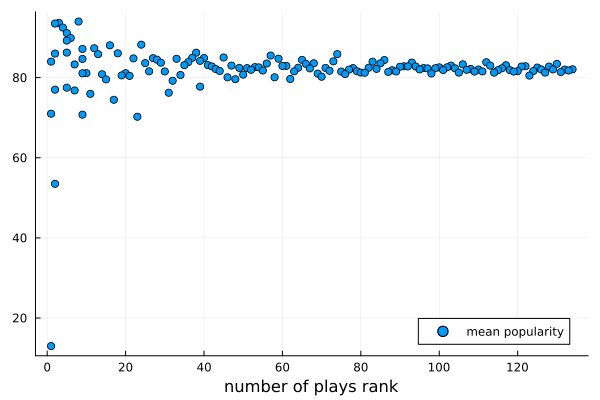

In [68]:
scatter(denserank(agg_popularity.Count), agg_popularity.MeanPopularity,
        label="mean popularity", xlabel="number of plays rank")

In [69]:
total_mean_popularity = mean(df.Popularity)

82.13027021957663

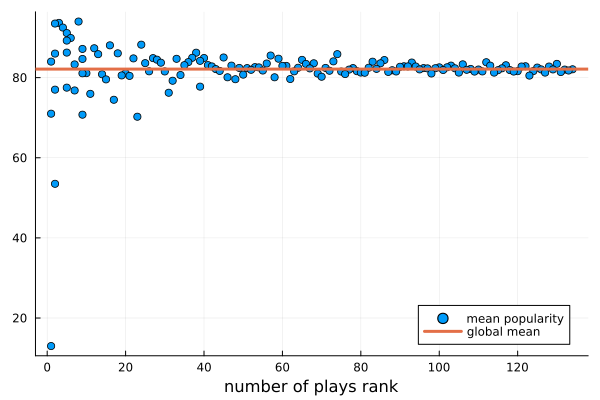

In [70]:
hline!([total_mean_popularity], label = "global mean", width=3)

In [71]:
agg_popularity_frequent = agg_popularity[agg_popularity.Count .> median(agg_popularity.Count), :]

73×4 DataFrame
 Row │ OpeningFamily            MeanPopularity  Count  VarPopularity 
     │ String                   Float64         Int64  Float64       
─────┼───────────────────────────────────────────────────────────────
   1 │ Catalan_Opening                 85.8613    923        475.684
   2 │ Latvian_Gambit                  84.4336    535        386.426
   3 │ Elephant_Gambit                 84.3877   1826        490.616
   4 │ Queens_Indian_Defense           84.0629    922        456.165
   5 │ Trompowsky_Attack               83.9779   1671        501.775
   6 │ Vienna_Game                     83.8439   6552        586.943
   7 │ Englund_Gambit_Complex          83.7681   2186        631.483
   8 │ Englund_Gambit_Declined         83.5819    708        598.21
  ⋮  │            ⋮                   ⋮           ⋮          ⋮
  67 │ Kings_Knight_Opening            81.221    1353        707.792
  68 │ Giuoco_Piano                    81.0339   2919        765.776
  69 │ St_George_Defense               81.0165    727        786.614
  70 │ Grob_Opening                    80.8954   1052        675.744
  71 │ Philidor_Defense                80.5083  12711        791.321
  72 │ London_System                   80.224     768        739.736
  73 │ Duras_Gambit                    79.6577    485        962.164
                                                      58 rows omitted

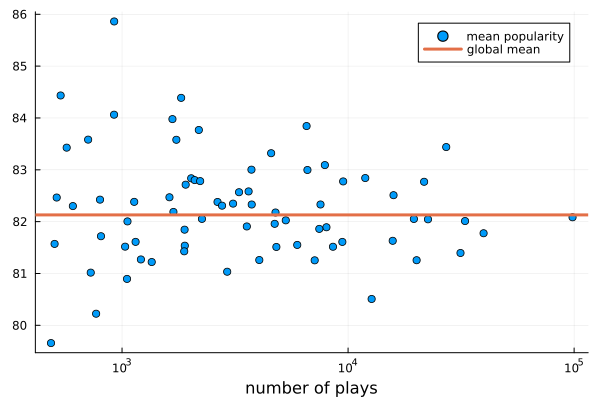

In [72]:
scatter(agg_popularity_frequent.Count, agg_popularity_frequent.MeanPopularity,
        label="mean popularity", xaxis=:log, xlabel="number of plays")
hline!([total_mean_popularity], label = "global mean", width=3)

In [73]:
agg_popularity_frequent.zscore = map(agg_popularity_frequent.MeanPopularity,
                                     agg_popularity_frequent.VarPopularity,
                                     agg_popularity_frequent.Count) do m, v, c
    (m - total_mean_popularity) / sqrt(v / c)
end

73-element Vector{Float64}:
  5.197243040936376
  2.7102440308589415
  4.355121311115467
  2.747606019713624
  3.3716207141544614
  5.7252819861077064
  3.0472267046113357
  1.5792541665937592
  2.4237869975882638
  8.772984789981662
  ⋮
 -4.531974089456253
 -2.7484680084502693
 -1.2571688113877402
 -2.1405089577390513
 -1.0707289446098764
 -1.5407249634544926
 -6.500644199071279
 -1.9423889603852464
 -1.7554538964494335

In [74]:
sort(agg_popularity_frequent, :zscore, rev=true, by=abs)

73×5 DataFrame
 Row │ OpeningFamily           MeanPopularity  Count  VarPopularity  zscore    ⋯
     │ String                  Float64         Int64  Float64        Float64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Caro-Kann_Defense              83.4388  27175        604.55    8.77298  ⋯
   2 │ Philidor_Defense               80.5083  12711        791.321  -6.50064
   3 │ Vienna_Game                    83.8439   6552        586.943   5.72528
   4 │ Catalan_Opening                85.8613    923        475.684   5.19724
   5 │ Italian_Game                   81.3955  31430        746.533  -4.7675   ⋯
   6 │ Ruy_Lopez                      81.2561  20101        747.959  -4.53197
   7 │ Elephant_Gambit                84.3877   1826        490.616   4.35512
   8 │ Scandinavian_Defense           82.7687  21695        642.239   3.71089
  ⋮  │           ⋮                   ⋮           ⋮          ⋮            ⋮     ⋱
  67 │ Benoni_Defense                 82.0253   5301        733.785  -0.282196 ⋯
  68 │ Saragossa_Opening              82.465     514        766.308   0.274125
  69 │ Danish_Gambit_Accepted         82.0047   1057        608.563  -0.16545
  70 │ Torre_Attack                   82.3003    606        758.991   0.151957
  71 │ Three_Knights_Opening          82.0532   2257        684.791  -0.139976 ⋯
  72 │ Alekhine_Defense               82.1763   4775        702.982   0.120056
  73 │ English_Defense                82.1872   1688        688.874   0.089121
                                                    1 column and 58 rows omitted

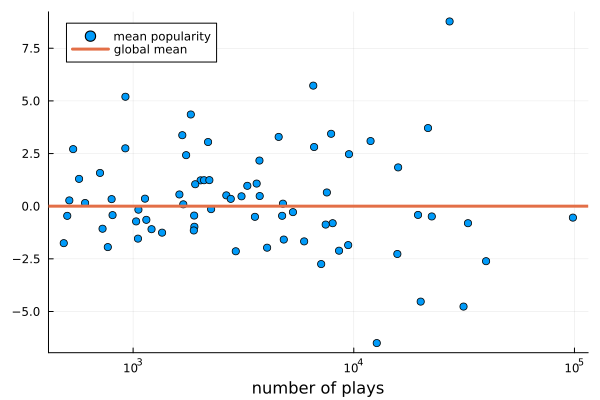

In [75]:
scatter(agg_popularity_frequent.Count, agg_popularity_frequent.zscore,
        label="mean popularity", xaxis=:log, xlabel="number of plays", legend=:topleft)
hline!([0.0], label = "global mean", width=3)

*Preparation of this worksop has been supported by the Polish National Agency for Academic Exchange under the Strategic Partnerships programme, grant number BPI/PST/2021/1/00069/U/00001.*

![SGH & NAWA](logo.png)